Inductive Matrix Completion Based On Graph Neural Networks
- Link: [Paper](https://openreview.net/pdf?id=ByxxgCEYDS)

In [44]:
# !conda install pyg -c pyg -y
# !pip install simpletransformers

In [45]:
from pathlib import Path
import sys
sys.path.append('../../')
import math

import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.loader import DataLoader

from dataset.movielens import MovieLensDataset
from models.igmc import IGMC
from helper.igmc_utils import *
import matplotlib.pyplot as plt

In [46]:
BASE_PATH = Path('../../raw_data/movie-lens/ml-latest-small')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
EPOCHS=20
BATCH_SIZE=512
LR=2e-3
LR_DECAY_STEP = 20
LR_DECAY_VALUE = 10

In [47]:
df_movies = pd.read_csv(BASE_PATH/'movies.csv')
df_links = pd.read_csv(BASE_PATH/'links.csv')
df_tags = pd.read_csv(BASE_PATH/'tags.csv')
df_ratings = pd.read_csv(BASE_PATH/'ratings.csv').drop(labels='timestamp', axis=1)

df_items, genres, genres_mp  = process_movies(df_movies, use_embeddings=True)
(rated_users, rated_users_dict, num_users), (rated_items, rated_items_dict, num_items), ratings = get_nodes(df_ratings)
item_features = get_item_features(df_items, rated_items_dict, sparse=False)
user_features = get_user_features(
    df_ratings, df_items, genres, genres_mp, 
    rated_users_dict, n=3, use_embeddings=True, 
    sparse=False,
)
class_values = np.sort(np.unique(ratings))
rating_dict = {r: i for i, r in enumerate(np.sort(np.unique(ratings)).tolist())}

c:\Users\naine\anaconda3\envs\las\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [48]:
df_movies.head(2)

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,feature
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,"[-0.4027835726737976, 0.14599479734897614, -0...."
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"[-0.40278360247612, 0.14599479734897614, -0.37..."


In [49]:
df_links.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [50]:
df_ratings.head(2)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0


In [51]:
df_tags.head(2)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


In [52]:
df_items.head(2)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,feature
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,"[-0.4027835726737976, 0.14599479734897614, -0...."
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[-0.40278360247612, 0.14599479734897614, -0.37..."


In [53]:
samples = (rated_users, rated_items, ratings)
user_train_idx, item_train_idx, user_test_idx, item_test_idx, train_labels, test_labels = split(samples, rating_dict)

data = train_labels + 1.
data = data.astype(np.float32)
adj_mat = sp.csr_matrix(
    (data, [user_train_idx, item_train_idx]), 
    shape=[num_users, num_items], 
    dtype=np.float32,
)

train_dataset = MovieLensDataset(
    root='../../raw_data/movie-lens/ml-latest-small',
    adj_mat=adj_mat,
    links=(user_train_idx, item_train_idx),
    labels=train_labels,
    h=1,
    sample_ratio=1,
    max_nodes_per_hop=200,
    u_features=user_features,
    v_features=item_features,
    class_values=class_values,
)

test_dataset = MovieLensDataset(
    root='../../raw_data/movie-lens/ml-latest-small',
    adj_mat=adj_mat,
    links=(user_test_idx, item_test_idx),
    labels=test_labels,
    h=1,
    sample_ratio=1,
    max_nodes_per_hop=200,
    u_features=user_features,
    v_features=item_features,
    class_values=class_values,
)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=0)

In [54]:
num_relations = len(class_values)
n_features = user_features.shape[1] + item_features.shape[1]
model = IGMC(
    train_dataset, 
    num_relations=num_relations, 
    num_bases=4,   
    side_features=True, 
    n_side_features=n_features, 
)

In [55]:
model.to(DEVICE)
model.reset_parameters()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=0)

epoch_losses = []
batch_losses = []
for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss_all = 0
    for idx, train_batch in enumerate(train_loader):
        optimizer.zero_grad()
        train_batch = train_batch.to(DEVICE)
        y_pred = model(train_batch)
        y_true = train_batch.y
        train_loss = F.mse_loss(y_pred, y_true)
        if idx % 20 == 0:
            print(round(train_loss.item(), 2), end=' ')
        train_loss.backward()
        train_loss_all += BATCH_SIZE * float(train_loss)
        optimizer.step()
        torch.cuda.empty_cache()
        batch_losses.append(train_loss)
        
    train_loss_all = train_loss_all / len(train_loader.dataset)
    epoch_losses.append(train_loss_all)

    
    print('epoch', epoch,'; train loss', train_loss_all)

    if epoch % LR_DECAY_STEP == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] / LR_DECAY_VALUE

14.45 1.24 1.05 1.12 1.11 1.13 1.09 1.04 epoch 1 ; train loss 1.2151915973514464
0.96 1.12 1.02 0.99 0.99 0.88 0.92 1.0 epoch 2 ; train loss 0.9842935039024487
1.12 0.91 0.99 0.96 0.95 0.98 0.92 0.99 epoch 3 ; train loss 0.9691937234219995
0.85 0.94 0.9 1.11 0.92 0.91 0.88 0.9 epoch 4 ; train loss 0.9386552776715549
0.9 0.89 0.92 0.88 0.9 0.94 0.93 0.97 epoch 5 ; train loss 0.9214169435155417
1.04 0.94 0.86 0.92 0.81 0.91 0.91 0.9 epoch 6 ; train loss 0.9208713368253016
0.83 0.97 0.89 0.94 0.88 0.89 0.98 1.08 epoch 7 ; train loss 0.9044300956459365
0.86 0.97 0.92 0.96 0.79 0.87 0.91 0.81 epoch 8 ; train loss 0.8958862799518067
0.9 0.83 0.96 0.93 0.91 0.84 0.86 0.93 epoch 9 ; train loss 0.895356138608343
0.86 0.99 0.88 0.87 0.86 0.83 0.87 0.91 epoch 10 ; train loss 0.8832588492774783
0.87 0.76 0.88 0.97 0.81 0.88 0.85 0.84 epoch 11 ; train loss 0.8789217085371813
0.88 0.9 0.85 1.01 0.88 0.81 0.8 0.82 epoch 12 ; train loss 0.8772886583338935
0.96 0.81 0.84 0.99 0.92 0.94 0.8 0.84 epoch 1

In [56]:
# model.to(DEVICE)
# model.reset_parameters()
# optimizer = Adam(model.parameters(), lr=LR, weight_decay=0)

# for epoch in range(1, EPOCHS+1):
#     model.train()
#     train_loss_all = 0
#     for idx, train_batch in enumerate(train_loader):
#         optimizer.zero_grad()
#         train_batch = train_batch.to(DEVICE)
#         y_pred = model(train_batch)
#         y_true = train_batch.y
#         train_loss = F.mse_loss(y_pred, y_true)
#         if idx % 20 == 0:
#             print(round(train_loss.item(), 2), end=' ')
#         train_loss.backward()
#         train_loss_all += BATCH_SIZE * float(train_loss)
#         optimizer.step()
#         torch.cuda.empty_cache()
        
#     train_loss_all = train_loss_all / len(train_loader.dataset)
    
#     print('epoch', epoch,'; train loss', train_loss_all)

#     if epoch % LR_DECAY_STEP == 0:
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = param_group['lr'] / LR_DECAY_VALUE

In [61]:
model.eval()
test_loss = 0
for test_batch in test_loader:
    test_batch = test_batch.to(DEVICE)
    with torch.no_grad():
        y_pred = model(test_batch)
    y_true = test_batch.y
    test_loss += F.mse_loss(y_pred, y_true, reduction='sum')
mse_loss = float(test_loss) / len(test_loader.dataset)

print('test MSE loss', mse_loss)
print('test RMSE loss', math.sqrt(mse_loss))

test MSE loss 0.7983738355625248
test RMSE loss 0.8935176750140563


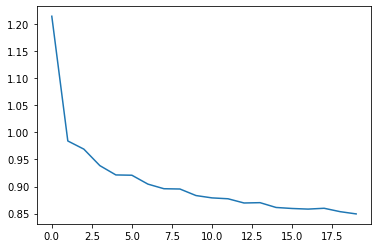

In [62]:
plt.plot(epoch_losses)

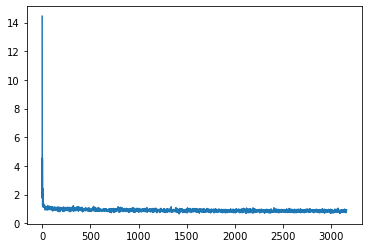

In [63]:
new_batch_losses = [loss.item() for loss in batch_losses]

plt.plot(new_batch_losses)

In [60]:
batch_losses[0].item()

14.445388793945312